# Project Work in Machine Learning for Computer Vision

In [ ]:
!pip install wandb
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 30.7 MB/s 
     |████████████████████████████████| 168 kB 93.8 MB/s 
     |████████████████████████████████| 182 kB 79.9 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 168 kB 97.5 MB/s 
     |████████████████████████████████| 166 kB 82.2 MB/s 
     |████████████████████████████████| 166 kB 98.5 MB/s 
     |████████████████████████████████| 162 kB 101.9 MB/s 
     |████████████████████████████████| 162 kB 77.4 MB/s 
     |████████████████████████████████| 158 kB 91.1 MB/s 
     |████████████████████████████████| 157 kB 77.7 MB/s 
     |████████████████████████████████| 157 kB 79.0 MB/s 
     |████████████████████████████████| 157 kB 93.7 MB/s 
     |████████████████████████████████| 157 kB 104.9 MB/s 
     |████████████████████████████████| 157 kB 103.6 MB/s 
     |████████████████████████

Imports

In [ ]:
from __future__ import print_function
from __future__ import division

import math
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import  transforms
from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
import wandb
import time
import os
from PIL import Image
from pathlib import Path
from torch.autograd import Variable
from torchvision.utils import save_image
from torchsummary import summary

Set fix random seed

In [ ]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True   

In [ ]:
fix_random(42)

Connect to google drive and prepare the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# copy the dataset in my google drive
# !cp "/content/drive/My Drive/ml4cv/places365.zip" "places365.zip"

In [ ]:
# this part is for data loading from kaggle
!pip install kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle 

!cp kaggle.json ~/.kaggle/ 

!chmod 600 ~/.kaggle/kaggle.json 

!kaggle datasets download -d mingziqi/places365

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 99% 249M/250M [00:16<00:00, 13.0MB/s]
100% 250M/250M [00:16<00:00, 15.9MB/s]


In [ ]:
!unzip -qq places365.zip

In [ ]:
!ls

kaggle.json  places365	places365.zip  sample_data


In [ ]:
!ls places365/

train  val


In [ ]:
# set path for the train and validation dataset
path_ds = 'places365'
path_ds_train = os.path.join(path_ds, 'train')
path_ds_val = os.path.join(path_ds, 'val')

Compute mean and std for the dataset

In [ ]:
def get_mean_and_std(dataset: torchvision.datasets.ImageFolder):
    """
    Args:
        dataset: the dataset. 
    Returns:
        The mean and the std on each channels computed over the dataset.
    """
    dataset_loader = DataLoader(
        dataset, batch_size=512, shuffle=False, pin_memory=True, num_workers=1
    )
    sums = torch.zeros(3)
    sums_of_square = torch.zeros(3)
    count = 0

    for images, _ in dataset_loader:
        b, _, h, w = images.shape
        num_pix_in_batch = b * h * w
        sums += torch.sum(images, dim=[0, 2, 3])
        sums_of_square += torch.sum(images ** 2, dim=[0, 2, 3])
        count += num_pix_in_batch

    mean = sums / count
    var = (sums_of_square / count) - (mean ** 2)
    std = torch.sqrt(var)
    
    return mean, std

In [ ]:
dataset_for_std = torchvision.datasets.ImageFolder(path_ds,transform=transforms.ToTensor())
mean_image_net, std_image_net = get_mean_and_std(dataset_for_std)
print(mean_image_net)
print(std_image_net)
# mean: tensor([0.4654, 0.4822, 0.4350])
# std: tensor([0.2569, 0.2562, 0.2976])

In [ ]:
MASK_SIZE = 128 
MASK_TYPE = 'random_region'  #center_mask / random_blocks / random_region
IMAGE_SIZE = 256
min_block_amount = 3   # random block min number
max_block_amount = 9   # random block max number
random_block_size = 20  # random block size
random_mask_path = '/content/drive/My Drive/ml4cv/random_mask_img'  
random_mask_path = 'random_region'  
random_masks = []   
inverse_random_masks = []

n_channels = 3
num_workers = 2 
size_batch = 16

lr= 0.0002  #learning rate
b1= 0.5    # adam beta 1
b2= 0.999  #adam beta 2
epochs = 300  #epochs I want to run
sample_interval = 100  # interval to save val image

min_gloss = 0.12 #minimum gloss for saving best model
min_loss_dic = 0.32 #minimum dloss for saving best model

Functions for creating different masks

In [ ]:
def create_center_mask(img):
    """
        create mask in the image's center

    Args:
        img: the img to generate mask. 
    Returns:
        1.the image with mask
        2. the original part that has been masked in the image
        3. the original image
        4. the mask
    """

    x1 = y1 = (IMAGE_SIZE - MASK_SIZE) // 2  # 64
    x2 = y2 = x1 + MASK_SIZE  # 192
    masked_img = img.clone()
    masked_img_copy = img.clone()
    missing_part = img.clone()
    mask = img.clone()

    missing_part[:] = 1
    missing_part[:, y1:y2, x1:x2] = masked_img_copy[:, y1:y2, x1:x2].clone()
    mask[:] = 0
    mask[:, y1:y2, x1:x2] = 1
    masked_img[:, y1:y2, x1:x2] = 0

    return masked_img, missing_part, img, mask


def create_random_blocks_mask(img):
    """
        create ramdom blocks mask for image
        
    Args:
        img: the image to generate mask. 
    Returns:
        1.the image with mask
        2. the original part that has been masked in the image
        3. the original image
        4. the mask
    """
    masked_img = img.clone()
    masked_img_copy = img.clone()
    missing_part = img.clone()
    missing_part[:] = 1
    mask = img.clone()
    mask[:] = 0
    blocks_amount = random.randint(min_block_amount, max_block_amount)
    for i in range(blocks_amount):
        y1 = random.randint(0, IMAGE_SIZE - random_block_size)  # (0, 107)
        y2 = y1 + random_block_size
        x1 = random.randint(0, IMAGE_SIZE - random_block_size)  # (0, 107)
        x2 = x1 + random_block_size
        masked_img[:, y1:y2, x1:x2] = 0
        missing_part[:, y1:y2, x1:x2] = masked_img_copy[:, y1:y2,
                                                        x1:x2].clone()
        mask[:, y1:y2, x1:x2] = 1

    return masked_img, missing_part, img, mask


def create_random_mask(img):
    """
        create random region mask in the image
        
    Args:
        img: the img to generate mask. 
    Returns:
        1.the image with mask
        2. the original part that has been masked in the image
        3. the original image
        4. the mask
    """
    global random_masks, inverse_random_masks
    arbi_mask_idx = np.random.randint(0, len(random_masks))
    random_mask = random_masks[arbi_mask_idx]
    inverse_random_mask = inverse_random_masks[arbi_mask_idx]

    masked_img = np.multiply(inverse_random_mask, img)
    missing_part = np.multiply(random_mask, img)

    return masked_img, missing_part, img, random_mask


def get_random_mask():
    """
        get all random region masks from the image folder
    """
    global random_masks, inverse_random_masks
    masks_photos_list = os.listdir(random_mask_path + "/")
    for mask in masks_photos_list:
        random_mask_name = random_mask_path + "/" + mask
        random_mask = Image.open(random_mask_name).convert(
            "L") 
        random_mask = random_mask.resize(
            (IMAGE_SIZE, IMAGE_SIZE),
            Image.ANTIALIAS) 
        random_mask = np.asarray(random_mask)
        random_mask, inverse_random_mask = get_inverse_mask(random_mask)

        dim1 = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        dim2 = np.add(dim1, random_mask)
        random_mask_3d = np.stack((random_mask, dim2, dim2), axis=0)
        if(random_mask_3d.sum() > int(IMAGE_SIZE*IMAGE_SIZE/4)):
          continue

        dim3 = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        dim4 = np.add(dim3, inverse_random_mask)
        inverse_random_mask_3d = np.stack((inverse_random_mask, dim4, dim4),
                                          axis=0)
        random_masks.append(random_mask_3d)
        inverse_random_masks.append(inverse_random_mask_3d)

    random_masks = np.asarray(random_masks)
    inverse_random_masks = np.asarray(inverse_random_masks)

def get_inverse_mask(random_mask):
    """
        create inverse mask.
        the pixel with value 1 in random mask will be 0 in inverse random mask.
        And vice versa.
    """
    inverse_random_mask_2d = np.copy(random_mask)
    random_mask_2d = np.copy(random_mask)
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            if inverse_random_mask_2d[i][j] != 0:
                inverse_random_mask_2d[i][j] = 0
                random_mask_2d[i][j] = 1
            else:
                inverse_random_mask_2d[i][j] = 1
                random_mask_2d[i][j] = 0
    return random_mask_2d, inverse_random_mask_2d

In [ ]:
# we need to get all the masks before create random region mask for the image
if MASK_TYPE == "random_region":
  get_random_mask()

Get data

In [ ]:
class Places365(Dataset):
    def __init__(
        self,
        path_images: str,
        mask_type: str,
        transforms: torchvision.transforms = None,
    ) -> None:
        super(Places365, self).__init__()

        self.images = sorted(
            [path for path in Path(path_images).rglob(f"*.jpg")])
        self.mask_type = mask_type
        self.transforms = transforms

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transforms is not None:
            image = self.transforms(image)

        if self.mask_type == 'center_mask':
            masked_img, missing_part, img, mask = create_center_mask(image)
        elif self.mask_type == 'random_blocks':
            masked_img, missing_part, img, mask = create_random_blocks_mask(
                image)
        else:
            masked_img, missing_part, img, mask = create_random_mask(image)

        return masked_img, missing_part, img, mask

    def __len__(self):
        return len(self.images)

In [ ]:
normalize = transforms.Normalize(mean_image_net, std_image_net)
denorm = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean_image_net, std_image_net)],
    std=[1.0 / s for s in std_image_net])
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor(), normalize]),
    'val': transforms.Compose([transforms.ToTensor(), normalize])
}

data_train = Places365(path_ds_train,
                       mask_type=MASK_TYPE,
                       transforms=data_transforms['train'])
data_val = Places365(path_ds_val,
                     mask_type=MASK_TYPE,
                     transforms=data_transforms['val'])

print(f'Samples -> Train = {len(data_train)} - Val = {len(data_val)} ')

Samples -> Train = 18000 - Val = 2000 


In [ ]:
# Loader
loader_train = DataLoader(data_train,
                          batch_size=size_batch,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=num_workers)
loader_val = DataLoader(data_val,
                        batch_size=size_batch,
                        shuffle=False,
                        num_workers=num_workers)


Visualize data

In [ ]:
train_dataiter = iter(loader_train)
disp_masked_img, disp_missing_part, disp_image, disp_mask = train_dataiter.next()

In [ ]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [ ]:
disp_image = denorm(disp_image)
disp_missing_part = torch.mul(disp_image,disp_mask)
disp_masked_img = torch.sub(disp_image,disp_missing_part)


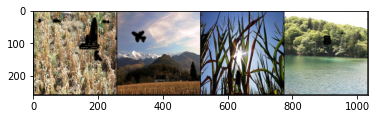

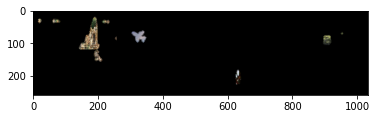

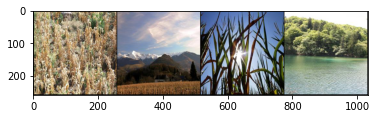

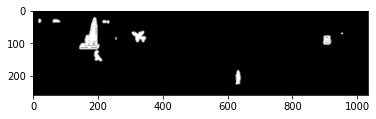

In [ ]:
show_grid(torchvision.utils.make_grid(disp_masked_img[:4]))
show_grid(torchvision.utils.make_grid(disp_missing_part[:4]))
show_grid(torchvision.utils.make_grid(disp_image[:4]))
show_grid(torchvision.utils.make_grid(disp_mask[:4]))

Model1: based on Context-Encoder and U-Net  

In [ ]:
class UConvDown(nn.Module):
    def __init__(self, num_convs, inchannels, outchannels, pool=True):
        """Construct a Down block for generator
        Parameters:
            num_convs (int)  : the number of Convolutional layer in down block
            inchannels (int) : the number of channels in input images
            outchannels (int) : the number of channels the layer outputs
            pool (bool) : Convolutional layer with kernel size = 3, stride = 2, padding = 1 will be added if it is ture
        """
        super(UConvDown, self).__init__()
        downLayer = []
        if pool:
            downLayer.append(
                nn.Conv2d(inchannels,
                          inchannels,
                          kernel_size=3,
                          stride=2,
                          padding=1))
            downLayer.append(nn.ReLU(inplace=True))
        for i in range(num_convs):
            if i == 0:
                downLayer.append(
                    nn.Conv2d(inchannels,
                              outchannels,
                              kernel_size=3,
                              padding=1))
            else:
                downLayer.append(
                    nn.Conv2d(outchannels,
                              outchannels,
                              kernel_size=3,
                              padding=1))
                downLayer.append(nn.BatchNorm2d(outchannels))
            downLayer.append(nn.ReLU(inplace=True))
        self.layer = nn.Sequential(*downLayer)

    def forward(self, x):
        return self.layer(x)


class UConvUp(nn.Module):
    def __init__(self, inchannels, outchannels):
        """Construct a Up block for generator
        Parameters:
            inchannels (int) : the number of channels in input images
            outchannels (int) : the number of channels the layer outputs
        """
        super(UConvUp, self).__init__()
        self.convt = nn.ConvTranspose2d(inchannels,
                                        outchannels,
                                        kernel_size=2,
                                        stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(inchannels, outchannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outchannels), nn.ReLU(inplace=True), 
            nn.Conv2d(outchannels, outchannels, kernel_size=3, padding=1),
            nn.BatchNorm2d(outchannels), nn.ReLU(inplace=True))

    def forward(self, x1, x2):
        x1 = self.convt(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.down1 = UConvDown(2, 3, 16, pool=False)
        self.down2 = UConvDown(3, 16, 32)
        self.down3 = UConvDown(3, 32, 64)
        self.down4 = UConvDown(3, 64, 128)
        self.down5 = UConvDown(3, 128, 256)
        self.up1 = UConvUp(256, 128)
        self.up2 = UConvUp(128, 64)
        self.up3 = UConvUp(64, 32)
        self.up4 = UConvUp(32, 16)
        self.out = nn.Sequential(
            nn.Conv2d(16, 3, kernel_size=1),
            nn.Tanh() 
        )

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, filter_num=64, n_layers=4):
        """Construct a PatchGAN discriminator
        Parameters:
            filter_num (int) : the number of filters in the last conv layer
            n_layers (int) : the number of convolutional layers in the discriminator
        """
        super(Discriminator, self).__init__()

        sequence = [
            nn.Conv2d(3,
                      filter_num,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      padding_mode="reflect"),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = 2**n
            sequence += [
                nn.Conv2d(filter_num * nf_mult_prev,
                          filter_num * nf_mult,
                          kernel_size=4,
                          stride=2,
                          padding=1,
                          padding_mode="reflect",
                          bias=False),
                nn.BatchNorm2d(filter_num * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        sequence += [
            nn.Conv2d(filter_num * nf_mult,
                      1,
                      kernel_size=4,
                      stride=1,
                      padding=1,
                      padding_mode="reflect"),
            nn.Sigmoid()
        ]
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


Context-Encoder

In [ ]:
class Generator_ce(nn.Module):
    def __init__(self):
        super(Generator_ce, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,64,4,2,1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64,128,4,2,1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128,256,4,2,1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256,512,4,2,1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512,4000,4, bias=False),
            nn.BatchNorm2d(4000),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(4000, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        
        output = self.main(input)
        return output

In [ ]:
class Discriminator_ce(nn.Module):
    def __init__(self):
        super(Discriminator_ce, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 4, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 4, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, input):
        return self.model(input).squeeze()

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

generator = Generator()
generator.apply(weights_init)
print(generator)
discriminator = Discriminator()
discriminator.apply(weights_init)
print(discriminator)

Generator(
  (down1): UConvDown(
    (layer): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
  )
  (down2): UConvDown(
    (layer): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
#loss function
adversarial_loss = torch.nn.BCELoss()
reconstruction_loss = torch.nn.MSELoss()

weight_adv =  0.001 # the weight of adversarial_loss

cuda = True if torch.cuda.is_available() else False
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    reconstruction_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2)) 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
# optimizer_G = torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9) 
# optimizer_D = torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
summary(generator, input_size=(3, 256, 256))
summary(discriminator, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 16, 256, 256]           2,320
       BatchNorm2d-4         [-1, 16, 256, 256]              32
              ReLU-5         [-1, 16, 256, 256]               0
         UConvDown-6         [-1, 16, 256, 256]               0
            Conv2d-7         [-1, 16, 128, 128]           2,320
              ReLU-8         [-1, 16, 128, 128]               0
            Conv2d-9         [-1, 32, 128, 128]           4,640
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]           9,248
      BatchNorm2d-12         [-1, 32, 128, 128]              64
             ReLU-13         [-1, 32, 128, 128]               0
           Conv2d-14         [-1, 32, 1

In [ ]:
x=torch.randn(1,3,256,256)
Discriminator()(x).shape
# patch = Discriminator()(x).shape

In [ ]:
patch = (1,15,15)

Weight & Biases config information

In [ ]:
config = {
    'epochs': epochs,
    'image_dims': (IMAGE_SIZE,IMAGE_SIZE),
    'n_channels': n_channels,
    'batch_size': size_batch
}
wandb.init(entity='yuweike', project='image_inpainting', name='imageInpainting', config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#training loop
def train():
    tqdm_bar = tqdm()
    for epoch in range(epochs):

        ### Training ###
        since = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')
        gen_adv_loss, gen_rec_loss, disc_loss, psnr_value = 0, 0, 0, 0
        gen_adv_losses, gen_rec_losses, disc_losses, g_losses = [], [], [], []
        tqdm_bar.reset(total=int(len(loader_train)))
        discriminator.train()
        generator.train()
        for i, (masked_imgs, missing_part, imgs, mask) in enumerate(loader_train):

            # label smoothing
            valid = Variable(Tensor(imgs.shape[0], *patch).fill_(0.9),
                            requires_grad=False).cuda()
            fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0),
                            requires_grad=False).cuda()
            # Configure input
            imgs = Variable(imgs.type(Tensor)).cuda()
            masked_imgs = Variable(masked_imgs.type(Tensor)).cuda()

            ### Train Discriminator  ###
            optimizer_D.zero_grad() 

            # train with real
            real_loss = adversarial_loss(discriminator(imgs), valid)
            real_loss.backward()

            #train with fake
            gen_images = generator(masked_imgs)
            fake_loss = adversarial_loss(discriminator(gen_images.detach()), fake)
            fake_loss.backward()

            d_loss = real_loss + fake_loss
            optimizer_D.step()

            ### Train Generator ###
            optimizer_G.zero_grad()  

            # Adversarial and reconstruction loss
            g_adv = adversarial_loss(discriminator(gen_images), valid)
            g_rec = reconstruction_loss(gen_images, imgs) 
            psnr_value += 20 * math.log10(1 / math.sqrt(g_rec))

            # Total loss
            g_loss = weight_adv * g_adv + (1 - weight_adv) * g_rec
            g_loss.backward()
            optimizer_G.step() 

            gen_adv_loss += g_adv.item()
            gen_rec_loss += g_rec.item()
            gen_adv_losses.append(g_adv.item())
            gen_rec_losses.append(g_rec.item())
            disc_loss += d_loss.item()
            disc_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

            tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss / (i + 1),
                                gen_rec_loss=gen_rec_loss / (i + 1),
                                disc_loss=disc_loss / (i + 1))
            tqdm_bar.update()

        ### validation ###
        discriminator.eval()
        generator.eval()
        loss_val = 0 
        psnr_val = 0
        losses_val = []
        tqdm_bar.reset(total=int(len(loader_val)))
        with torch.no_grad():
            for i, (masked_imgs_val, missing_part_val, imgs_val,
                    mask_val) in enumerate(loader_val):
                imgs_val = Variable(imgs_val.type(Tensor)).cuda()
                masked_imgs_val = Variable(masked_imgs_val.type(Tensor)).cuda()
                mask_val = Variable(mask_val.type(Tensor)).cuda()
                generated_images = generator(masked_imgs_val)
                rec_val = reconstruction_loss(generated_images, imgs_val)
                loss_val += rec_val.item()
                losses_val.append(rec_val.item())
                psnr_val += 20 * math.log10(1 / math.sqrt(rec_val))

                # Generate sample at sample interval
                batches_done = epoch * len(loader_val) + i
                if batches_done % size_batch == 0:
                    generated_mask_part = torch.mul(generated_images, mask_val)
                    img_display = torch.add(generated_mask_part, masked_imgs_val)
                    masked_imgs_val = denorm(masked_imgs_val)
                    masked_imgs_val = torch.mul(
                        masked_imgs_val,
                        torch.sub(torch.ones(mask_val.shape).cuda(), mask_val))
                    img_display = denorm(img_display)
                    generated_images = denorm(generated_images)
                    imgs_val = denorm(imgs_val)
                    sample = torch.cat((masked_imgs_val.data[:4],
                                        img_display.data[:4], imgs_val.data[:4]),
                                    -2)
                    wandb.log(
                        {
                            "masked-prediction-groundTurth":
                            wandb.Image(torchvision.utils.make_grid(sample))
                        },
                        step=epoch)
                tqdm_bar.update()


        #computer and print loss
        train_adv_loss = sum(gen_adv_losses) / len(gen_adv_losses)
        train_rec_loss = sum(gen_rec_losses) / len(gen_rec_losses)
        train_disc_loss = sum(disc_losses) / len(disc_losses)
        train_gloss = sum(g_losses) / len(g_losses)
        train_psnr = psnr_value / len(loader_train)
        val_rec_loss = sum(losses_val) / len(losses_val)
        val_psnr = psnr_val / len(losses_val)
        print(
            f'Train adv Loss: {train_adv_loss} - Train rec loss: {train_rec_loss} - Train disc loss: {train_disc_loss} - Train gloss: {train_gloss}'
        )
        print(f'Validation Loss: {val_rec_loss}')
        wandb.log(
            {
                'train_adv_loss': train_adv_loss,
                'train_rec_loss': train_rec_loss,
                'train_disc_loss': train_disc_loss,
                'val_rec_loss': val_rec_loss,
                'Train gloss': train_gloss,
                'trian_psnr': train_psnr,
                'val_psnr': val_psnr
            },
            step=epoch)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))


In [ ]:
train()

0it [00:00, ?it/s]

Epoch: 1/300
Train adv Loss: 2.706608590867784 - Train rec loss: 0.18437869317001768 - Train disc loss: 0.6392279773288303 - Train gloss: 0.18690092595418295
Validation Loss: 0.12098506420850753
Training complete in 1m 38s
Epoch: 2/300
Train adv Loss: 4.770112627983093 - Train rec loss: 0.12179233970907 - Train disc loss: 0.36758597985903424 - Train gloss: 0.12644066172838211
Validation Loss: 0.11236129432916642
Training complete in 1m 36s
Epoch: 3/300
Train adv Loss: 4.695441083166334 - Train rec loss: 0.11531260556644864 - Train disc loss: 0.41640699415736726 - Train gloss: 0.11989273578590817
Validation Loss: 0.10979258984327317
Training complete in 1m 37s
Epoch: 4/300
Train adv Loss: 5.174924331559075 - Train rec loss: 0.11280791313780679 - Train disc loss: 0.37225586393144394 - Train gloss: 0.11787003133032058
Validation Loss: 0.10741848838329315
Training complete in 1m 37s
Epoch: 5/300
Train adv Loss: 5.5663094339370724 - Train rec loss: 0.1113670399983724 - Train disc loss: 0.36